# M2177.003100 Deep Learning Assignment #2<br> Part 1. Denoising Diffusion Probabilistic Models (Pytorch)

---



Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them.

**For understanding of this work, please carefully look at given PDF file.**

In this notebook, you will learn how to train denoising diffusion probabilistic models.
There are 3 sections, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

**DO NOT clear the final outputs so that TAs can grade both your code and results.**

## 1. Setup

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster.

In [1]:
!nvidia-smi

Wed Dec  6 16:46:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.02              Driver Version: 536.19       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti     On  | 00000000:01:00.0  On |                  N/A |
| 30%   41C    P8              23W / 200W |   2140MiB /  8192MiB |     38%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, install and import necessary libraries.
You can import additional libraries if necessary,<br>
but using libraries such as diffusers which already have the materials for this assignment are **NOT** allowed.

In [2]:
!pip3 install torch torchvision

In [3]:
import os
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np

Download and setup the CIFAR-10 dataset we will be using.

In [4]:
###### Data Setting

batch_size = 64                 # the number of data in each iteration

# optionally load a model
tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

dataset = MNIST("./data", train=True, download=True, transform=tf)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Check example images.

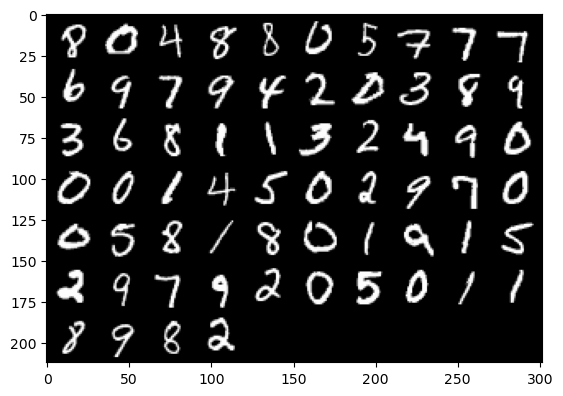

In [5]:
sample_batch = next(iter(dataloader))[0][:100]

plt.imshow(make_grid(sample_batch, nrow=10).permute(1, 2, 0))
plt.show()
plt.close()

## 2. Noise Scheduling
### 2.1 Beta schedule: implement the two typically used noise schedule for diffusion models:
* Linear schedule<br>
: linearly increase $\beta_t$ from $\beta_1=10^{-4}$ to $\beta_T = 0.02$

* Cosine schedule<br>
: $\beta_t$ = clip$(1 - \frac{\bar{\alpha_t}}{\bar{\alpha}_{t-1}}, 0.999)$,<br>
$\bar{\alpha_t} = \frac{f(t)}{f(0)}$ where $f(t) = \cos^2(\frac{t/T + s}{1 + s} \cdot \frac{\pi}{2})$ <br>
small offset $s$: to prevent $\beta_t$ from being too small when close to 0. Here, we set $s=0.008$.


#### 2.2 Pre-compute necessary values of the noise schedule:
* beta_t: $\beta_t$
* sqrt_beta_t: $\sqrt{\beta_t}$
* alpha_t: $\alpha_t:=1-\beta_t$
* alphabar_t: $\bar{\alpha_t} := ∏_{i=1}^{t}\alpha_t$
* sqrtab: $\sqrt{\bar{\alpha_t}}$
* oneover_sqrta: $\frac{1}{\sqrt{\alpha_t}}$
* sqrtmab: $\sqrt{1-\bar{\alpha_t}}$
* bt_over_sqrtmab: $\frac{\beta_t}{\sqrt{1-\bar{\alpha_t}}}$




In [6]:
def beta_schedule(beta1, beta2, T, schedule='linear'):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################

    if schedule == 'linear':
        betas = torch.linspace(beta1, beta2, T)


    elif schedule == 'cosine':
        s = 0.008

        x = torch.linspace(0, T, T + 1)
        f_t = torch.cos(((x / T + s) / (1 + s) * torch.pi * 0.5)) ** 2
        alpha_bar = f_t / f_t[0]
        betas = 1 - (alpha_bar[1:] / alpha_bar[:-1])
        betas = torch.clip(betas, 0.000, 0.999)

    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################
    return betas

def ddpm_schedules(beta1, beta2, T, schedule='linear'):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"


    beta_t = beta_schedule(beta1, beta2, T, schedule)
    
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################

    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    alphabar_t = torch.cumprod(alpha_t, dim=0)
    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    bt_over_sqrtmab_inv = beta_t / sqrtmab

    ##############################################################################
    #                          END OF YOUR CODE                                  #
    ##############################################################################

    return {
        "beta_t": beta_t,                          # \beta_t
        "sqrt_beta_t": sqrt_beta_t,                # \sqrt{\beta_t}
        "alpha_t": alpha_t,                        # \alpha_t
        "alphabar_t": alphabar_t,                  # \bar{\alpha_t}
        "sqrtab": sqrtab,                          # \sqrt{\bar{\alpha_t}}
        "oneover_sqrta": oneover_sqrta,            # 1/\sqrt{\alpha_t}
        "sqrtmab": sqrtmab,                        # \sqrt{1-\bar{\alpha_t}}
        "bt_over_sqrtmab": bt_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }



Visualize and check your implementation of scheduling.

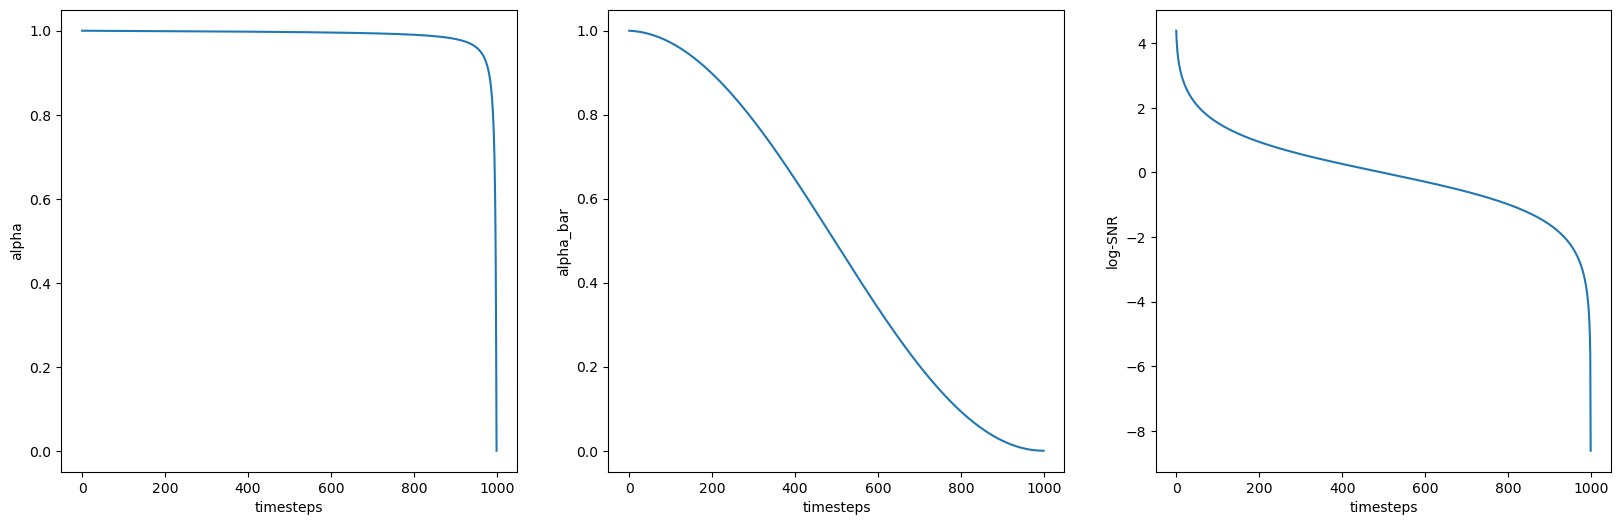

In [7]:
# ddpm scheduling check

import matplotlib.pyplot as plt

n_T = 1000

ddpm_scheduling_dict = ddpm_schedules(1e-4, 0.02, n_T, schedule='cosine')

beta = ddpm_scheduling_dict['beta_t']
alpha = ddpm_scheduling_dict['alpha_t']
alpha_bar = ddpm_scheduling_dict['alphabar_t']
oneover_sqrta = ddpm_scheduling_dict['oneover_sqrta']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,6))

axes[0].plot(np.arange(len(alpha)), alpha)
axes[0].set_xlabel('timesteps')
axes[0].set_ylabel('alpha')

axes[1].plot(np.arange(len(alpha_bar)), alpha_bar)
axes[1].set_xlabel('timesteps')
axes[1].set_ylabel('alpha_bar')

axes[2].plot(np.arange(len(alpha_bar)), np.log10(alpha_bar / (1 - alpha_bar)))
axes[2].set_xlabel('timesteps')
axes[2].set_ylabel('log-SNR')

plt.show()
plt.close()

Visualize and check the forward diffusion process with your implemented schedule.

* **forward_list** will visualize the original sequential forward process
* **forward_list2** will visualize the forward process using reparameterization trick.

If implemented correctly, the two should look alike.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


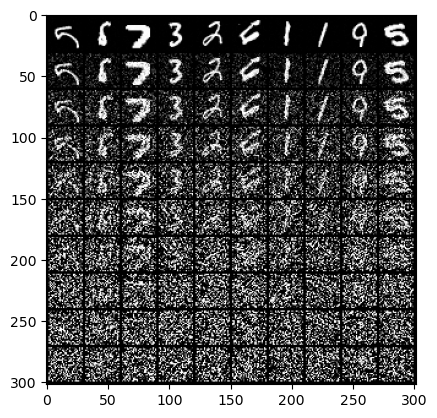

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


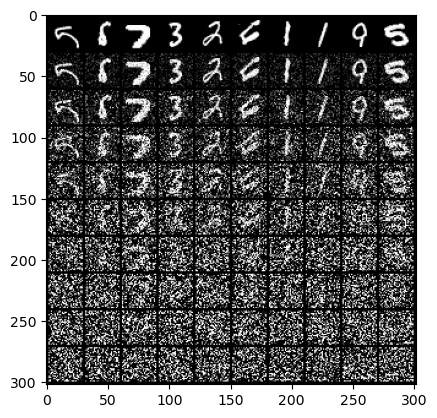

In [8]:
sample_batch = next(iter(dataloader))[0][:10]

forward_list = []
forward_list2 = []

x = sample_batch
for t in range(n_T):
    x = torch.sqrt(1 - ddpm_scheduling_dict['beta_t'][t, None, None, None]) * x + torch.sqrt(ddpm_scheduling_dict['beta_t'][t, None, None, None]) * torch.randn_like(x)
    if t % (n_T//10) == 0:
        forward_list.append(x.detach().cpu())

for t in range(n_T):
    if t % (n_T//10) == 0:
        x = ddpm_scheduling_dict['sqrtab'][t, None, None, None] * sample_batch + ddpm_scheduling_dict['sqrtmab'][t, None, None, None] * torch.randn_like(sample_batch)
        forward_list2.append(x.detach().cpu())

plt.imshow(make_grid(torch.cat(forward_list), nrow=10).permute(1, 2, 0), cmap='gray')
plt.show()
plt.close()

plt.imshow(make_grid(torch.cat(forward_list2), nrow=10).permute(1, 2, 0), cmap='gray')
plt.show()
plt.close()

## 3. The U-Net architecture for diffusion models.
Diffusion Models typically use a timestep-conditioned U-Net architecture. <br>
In this assignment, the U-Net is given as below. <br>
You may adjust the architecture if necessary.

In [9]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t):
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # convert context to one hot embedding
        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        # embed context, time step
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1+ temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## 4. Build the diffusion model wrapper.

#### 4.1 forward( ): implement the loss computation for diffusion model.
* Given a sample $x_0$, random timestep $t$ and noise $\epsilon$, compute the noisy sample
$x_t=\sqrt{\bar{\alpha_t}}x_0 + \sqrt{1 - \bar{\alpha_t}}\epsilon$ .

* Forward the inputs through the network, and compute the loss between prediction and the ground-truth.



#### 4.2 sample( ): Implement a sampling step with diffusion model.
* Given a batch of random noise **x_i** and class labels **c_i**, generate a class-conditioned image.

* Save the intermediate results in the list **x_i_store** for visualization.

  * Saving the intermediate results as all timesteps would be inefficient; thus it is recommended to save results every N steps (e.g., save every 25 steps)



#### 4.3 Implementation for different prediction types
* Typically, prediction of the noise $\epsilon$ or the original sample $x_0$ are popular choices.
* Implement the loss computation and the sampling process for both ($\epsilon$, $x_0$) prediction types.

In [10]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, prediction_type, schedule, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        # register_buffer allows accessing dictionary produced by ddpm_schedules
        # e.g. can access self.sqrtab later
        for k, v in ddpm_schedules(betas[0], betas[1], n_T, schedule).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        assert prediction_type in ['epsilon', 'sample'], 'prediction type needs to be either one of epsilon or sample (x_0).'
        self.prediction_type = prediction_type
        self.device = device

    def forward(self, x, c):
        """
        this method is used in training, sample t and noise randomly.
        """

        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        if self.prediction_type == 'epsilon':
            rand_ts = torch.randint(1, self.n_T, (x.shape[0],)).to(x.device)
            noise = torch.randn_like(x)
            x_t = self.sqrtab[rand_ts, None, None, None] * x + self.sqrtmab[rand_ts, None, None, None] * noise
            predicted_noise = self.nn_model(x_t, c, rand_ts / self.n_T)
            loss = F.mse_loss(noise, predicted_noise)

        elif self.prediction_type == 'sample':
            rand_ts = torch.randint(1, self.n_T, (x.shape[0],)).to(x.device)
            eps = torch.randn_like(x)
            x_t = (self.sqrtab[rand_ts, None, None, None] * x + self.sqrtmab[rand_ts, None, None, None] * eps)
            predicted_x0 = self.nn_model(x_t, c, rand_ts / self.n_T)
            loss = F.mse_loss(x, predicted_x0)

        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

        return loss  # return the loss

    def sample(self, n_sample, size, device):
        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1), sample initial noise
        c_i = torch.arange(0, 10).to(device)  # the mnist labels
        assert n_sample % c_i.shape[0] == 0, 'number of samples must be a multiple of 10.'
        c_i = c_i.repeat(int(n_sample/c_i.shape[0]))  # make n_samples
        x_i_store = [] # keep track of generated steps to plot the reverse process: save intermediate results

        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

        if self.prediction_type == 'epsilon':
            for i in range(self.n_T-1, -1, -1):
                ts = torch.tensor([i / self.n_T]).to(device)
                predicted_noise = self.nn_model(x_i, c_i, ts)
                
                z = 0 if i == 0 else torch.randn(n_sample, *size).to(device)
                x_i = (
                    self.oneover_sqrta[i, None, None, None] * (
                        x_i - (1 - self.alpha_t[i, None, None, None]) / self.sqrtmab[i, None, None, None] * predicted_noise
                    ) + self.sqrt_beta_t[i, None, None, None] * z
                )

                if i%20==0:
                    x_i_store.append(x_i.detach().cpu())
        
        elif self.prediction_type == 'sample':
            for i in range(self.n_T-1, -1, -1):
                ts = torch.tensor([i / self.n_T]).to(device)
                predicted_x0 = self.nn_model(x_i, c_i, ts)
                
                if i == 0:
                    pass
                    x_i = predicted_x0
                else:
                    z = torch.randn(n_sample, *size).to(device)
                    x_i = (
                        self.sqrtab[i-1, None, None, None] * self.beta_t[i, None, None, None] * predicted_x0
                        + torch.sqrt(self.alpha_t[i, None, None, None]) * (1 - self.alphabar_t[i-1, None, None, None]) * x_i
                    ) / (1 - self.alphabar_t[i, None, None, None]) + self.sqrt_beta_t[i, None, None, None] * z

                if i%20==0:
                    x_i_store.append(x_i.detach().cpu())


        ##############################################################################
        #                          END OF YOUR CODE                                  #
        ##############################################################################

        x_i_store = np.array(x_i_store)
        return x_i, x_i_store

## 5. Train
Now, let's try training the diffusion model.
Configure the hyperparameters as you like, and try to get a good generation quality.

**DO NOT** change the two settings below.
* n_classes: number of classes (10) will be used for generating all ten digits.
* save_dir: path to save the results of your experiments. If you change it, it may be left during compression.

You may adjust other parts of the code if necessary.


In [11]:
device='cuda'
n_epoch = 50                   # total training epoch
n_T = 1000                      # total timesteps of diffusion process
betas = (1e-4, 0.02)            # beta schedule
n_classes = 10                  # the number of class in dataset
n_feat = 256                    # feature dimension of UNet
lr = 1e-5                       # learning rate
prediction_type = 'sample'     # prediction type of diffusion models: epsilon (noise) or sample (x_0)
schedule = 'linear'             # noise schedule

# to save results
save_dir = f'./results_{prediction_type}_{schedule}/'  # DO NOT change this part, or else it could be left out when compressing.
os.makedirs(save_dir, exist_ok=True)
save_every = 10

nn_model = ContextUnet(in_channels=1, n_feat=n_feat, n_classes=n_classes)
ddpm = DDPM(nn_model=nn_model, betas=betas, n_T=n_T, prediction_type=prediction_type, schedule=schedule, device=device)
ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)                # set optimizer for training.

In [12]:
# Training
for ep in range(n_epoch):
    print(f'epoch {ep}')
    ddpm.train()

    pbar = tqdm(dataloader)
    loss_ema = None
    for x, c in pbar:
        optim.zero_grad()
        x = x.to(device)
        c = c.to(device)
        loss = ddpm(x, c)
        loss.backward()
        if loss_ema is None:
            loss_ema = loss.item()
        else:
            loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
        pbar.set_description(f"loss: {loss_ema:.4f}")
        optim.step()

    # for eval, save an image of currently generated samples (top rows)
    # followed by real images (bottom rows)
    if ep % save_every == 0 or ep == int(n_epoch - 1):
        ddpm.eval()
        with torch.no_grad():
            n_sample = 4*n_classes
            x_gen, x_gen_store = ddpm.sample(n_sample, (1, 28, 28), device)
            print(x_gen_store[0].max(), x_gen_store[0].min())
            print(x_gen_store[-1].max(), x_gen_store[-1].min())

            # append some real images at bottom, order by class also
            x_real = torch.Tensor(x_gen.shape).to(device)
            for k in range(n_classes):
                for j in range(int(n_sample/n_classes)):
                    try:
                        idx = torch.squeeze((c == k).nonzero())[j]
                    except:
                        idx = 0
                    x_real[k+(j*n_classes)] = x[idx]

            x_all = torch.cat([x_gen, x_real])
            grid = make_grid(x_all, nrow=10)
            if ep == int(n_epoch - 1):
                save_image(grid, save_dir + f"image_final.png")
                print('saved image at ' + save_dir + f"image_final.png")
            else:
                save_image(grid, save_dir + f"image_ep{ep}.png")
                print('saved image at ' + save_dir + f"image_ep{ep}.png")

            # create gif of images evolving over time, based on x_gen_store
            fig, axs = plt.subplots(nrows=int(n_sample/n_classes), ncols=n_classes,sharex=True,sharey=True,figsize=(8,3))
            def animate_diff(i, x_gen_store):
                print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                plots = []
                for row in range(int(n_sample/n_classes)):
                    for col in range(n_classes):
                        axs[row, col].clear()
                        axs[row, col].set_xticks([])
                        axs[row, col].set_yticks([])
                        plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray',vmin=(x_gen_store[i]).min(), vmax=(x_gen_store[i]).max()))
                return plots
            ani = FuncAnimation(fig, animate_diff, fargs=[x_gen_store],  interval=200, blit=False, repeat=True, frames=x_gen_store.shape[0])
            if ep == int(n_epoch - 1):
                ani.save(save_dir + f"gif_final.gif", dpi=100, writer=PillowWriter(fps=5))
                print('saved image at ' + save_dir + f"gif_final.gif")
            else:
                ani.save(save_dir + f"gif_ep{ep}.gif", dpi=100, writer=PillowWriter(fps=5))
                print('saved image at ' + save_dir + f"gif_ep{ep}.gif")
            plt.close('all')

    # save model
    if ep == int(n_epoch-1):
        torch.save(ddpm.state_dict(), save_dir + f"model_final.pth")
        print('saved model at ' + save_dir + f"model_final.pth")

epoch 0


loss: 0.0415: 100%|██████████| 938/938 [02:34<00:00,  6.08it/s]


4.01939 -4.2055426
1.2790896 -0.19558354
saved image at ./results_sample_linear/image_ep0.png
saved image at ./results_sample_linear/gif_ep0.gif
epoch 1


loss: 0.0406: 100%|██████████| 938/938 [02:33<00:00,  6.10it/s]


epoch 2


loss: 0.0403: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 3


loss: 0.0386: 100%|██████████| 938/938 [02:30<00:00,  6.21it/s]


epoch 4


loss: 0.0387: 100%|██████████| 938/938 [02:31<00:00,  6.19it/s]


epoch 5


loss: 0.0379: 100%|██████████| 938/938 [02:31<00:00,  6.21it/s]


epoch 6


loss: 0.0381: 100%|██████████| 938/938 [02:32<00:00,  6.17it/s]


epoch 7


loss: 0.0378: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 8


loss: 0.0379: 100%|██████████| 938/938 [02:32<00:00,  6.14it/s]


epoch 9


loss: 0.0361: 100%|██████████| 938/938 [02:32<00:00,  6.15it/s]


epoch 10


loss: 0.0369: 100%|██████████| 938/938 [02:31<00:00,  6.19it/s]


4.2358966 -4.00098
1.1051453 -0.114140086
saved image at ./results_sample_linear/image_ep10.png
saved image at ./results_sample_linear/gif_ep10.gif
epoch 11


loss: 0.0370: 100%|██████████| 938/938 [02:32<00:00,  6.17it/s]


epoch 12


loss: 0.0371: 100%|██████████| 938/938 [02:32<00:00,  6.17it/s]


epoch 13


loss: 0.0366: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 14


loss: 0.0370: 100%|██████████| 938/938 [02:29<00:00,  6.26it/s]


epoch 15


loss: 0.0368: 100%|██████████| 938/938 [02:28<00:00,  6.32it/s]


epoch 16


loss: 0.0353: 100%|██████████| 938/938 [02:30<00:00,  6.25it/s]


epoch 17


loss: 0.0372: 100%|██████████| 938/938 [02:32<00:00,  6.15it/s]


epoch 18


loss: 0.0376: 100%|██████████| 938/938 [02:33<00:00,  6.13it/s]


epoch 19


loss: 0.0373: 100%|██████████| 938/938 [02:32<00:00,  6.14it/s]


epoch 20


loss: 0.0370: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


5.1015406 -4.0175
1.0547881 -0.19854742
saved image at ./results_sample_linear/image_ep20.png
saved image at ./results_sample_linear/gif_ep20.gif
epoch 21


loss: 0.0363: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 22


loss: 0.0370: 100%|██████████| 938/938 [02:30<00:00,  6.21it/s]


epoch 23


loss: 0.0377: 100%|██████████| 938/938 [02:29<00:00,  6.25it/s]


epoch 24


loss: 0.0357: 100%|██████████| 938/938 [02:32<00:00,  6.14it/s]


epoch 25


loss: 0.0357: 100%|██████████| 938/938 [02:32<00:00,  6.15it/s]


epoch 26


loss: 0.0363: 100%|██████████| 938/938 [02:32<00:00,  6.17it/s]


epoch 27


loss: 0.0364: 100%|██████████| 938/938 [02:32<00:00,  6.15it/s]


epoch 28


loss: 0.0365: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 29


loss: 0.0363: 100%|██████████| 938/938 [02:31<00:00,  6.18it/s]


epoch 30


loss: 0.0365: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


4.589265 -4.219868
1.0796819 -0.0846156
saved image at ./results_sample_linear/image_ep30.png
saved image at ./results_sample_linear/gif_ep30.gif
epoch 31


loss: 0.0361: 100%|██████████| 938/938 [02:32<00:00,  6.14it/s]


epoch 32


loss: 0.0362: 100%|██████████| 938/938 [02:32<00:00,  6.13it/s]


epoch 33


loss: 0.0363: 100%|██████████| 938/938 [02:32<00:00,  6.17it/s]


epoch 34


loss: 0.0361: 100%|██████████| 938/938 [02:31<00:00,  6.17it/s]


epoch 35


loss: 0.0366: 100%|██████████| 938/938 [02:31<00:00,  6.20it/s]


epoch 36


loss: 0.0368: 100%|██████████| 938/938 [02:31<00:00,  6.17it/s]


epoch 37


loss: 0.0349: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 38


loss: 0.0360: 100%|██████████| 938/938 [02:31<00:00,  6.18it/s]


epoch 39


loss: 0.0354: 100%|██████████| 938/938 [02:31<00:00,  6.18it/s]


epoch 40


loss: 0.0360: 100%|██████████| 938/938 [02:31<00:00,  6.17it/s]


3.96869 -3.8259456
1.0839915 -0.11066378
saved image at ./results_sample_linear/image_ep40.png
saved image at ./results_sample_linear/gif_ep40.gif
epoch 41


loss: 0.0364: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 42


loss: 0.0359: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 43


loss: 0.0360: 100%|██████████| 938/938 [02:31<00:00,  6.18it/s]


epoch 44


loss: 0.0351: 100%|██████████| 938/938 [02:30<00:00,  6.25it/s]


epoch 45


loss: 0.0359: 100%|██████████| 938/938 [02:30<00:00,  6.25it/s]


epoch 46


loss: 0.0356: 100%|██████████| 938/938 [02:32<00:00,  6.15it/s]


epoch 47


loss: 0.0357: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 48


loss: 0.0366: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


epoch 49


loss: 0.0369: 100%|██████████| 938/938 [02:32<00:00,  6.16it/s]


3.791454 -4.0163984
1.0786467 -0.10942556
saved image at ./results_sample_linear/image_final.png
saved image at ./results_sample_linear/gif_final.gif
saved model at ./results_sample_linear/model_final.pth


## 6. Inference
With your trained model, try generating random samples with your model.

In [13]:
# ddpm.load_state_dict(torch.load('./results_epsilon_cosine/model_final.pth'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


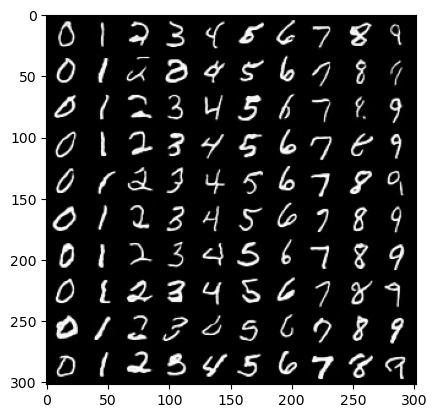

In [14]:
num_samples = 100
with torch.no_grad():
    x_gen, x_gen_store = ddpm.sample(num_samples, (1, 28, 28), device)

plt.imshow(make_grid(x_gen.cpu(), nrow=10).permute(1, 2, 0))
plt.show()
plt.close()

In [15]:
print(x_gen.max(), x_gen.min())

tensor(1.0931, device='cuda:0') tensor(-0.1348, device='cuda:0')
